In [99]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from pydantic import BaseModel, Field

In [100]:
load_dotenv()

True

In [101]:
model = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)

In [102]:
class SentimentSchema(BaseModel):
    sentiment: Literal["positive", "negative", "neutral"] = Field(description="The sentiment of the review")
    

class DiagnosisSchema(BaseModel):
    issue: Literal["billing", "technical", "customer_service", "other"] = Field(description="The issue category metioned in the review") 
    tone: Literal["angry", "frustrated", "disappointed", "neutral"] = Field(description="The tone of the review which can be used to determine the urgency of the response")
    urgency: Literal["low", "medium", "high"] = Field(description="The urgency of the response based on the issue, tone and sentiment of the review")

In [103]:
structured_model = model.with_structured_output(SentimentSchema)
structured_diagnosis_model = model.with_structured_output(DiagnosisSchema)

In [104]:
class ReviewState(TypedDict):
    review: str
    sentiment: Literal["positive", "negative", "neutral"]
    diagnosis: dict
    response: str


In [105]:
def find_sentiment_node(state: ReviewState):
    prompt = f"Given the following review, determine if the sentiment is positive, negative, or neutral:\n\n{state['review']}"
    sentiment = structured_model.invoke(prompt).sentiment
    return {"sentiment": sentiment}

def check_sentiment_node(state: ReviewState) -> Literal["positive_response", "neutral_response", "run_diagnosis"]:
    if state['sentiment'] == "positive":
        return "positive_response"
    elif state["sentiment"] == "neutral":
        return "neutral_response"
    else:
        return "run_diagnosis"
    
def positive_response(state: ReviewState):
    prompt = f"""Write a warm and appreciative response to the following positive review:\n\n{state['review']} \n 
    Also kindly ask them to share their experience on social media and our website."""
    response = model.invoke(prompt).content
    return {"response": response}

def run_diagnosis(state: ReviewState):
    prompt = f"""Given the following negative review, identify the main issues and provide a diagnosis in a JSON format with the following keys: 'issue', 'tone', and 'urgency'.\n\n{state['review']}"""
    diagnosis = structured_diagnosis_model.invoke(prompt)
    return {"diagnosis": diagnosis.model_dump()}

def negative_response(state: ReviewState):
    prompt = f"""Write a professional and empathetic response to the following negative review, addressing the identified issues and offering a solution:\n\nReview: {state['review']}\n\nDiagnosis: {state['diagnosis']}"""
    response = model.invoke(prompt).content
    return {"response": response}

def neutral_response(state: ReviewState):
    prompt = f"""Write a polite and constructive response to the following neutral review, acknowledging their feedback and inviting them to share more details or how we can be better:\n\n{state['review']}"""
    response = model.invoke(prompt).content
    return {"response": response}

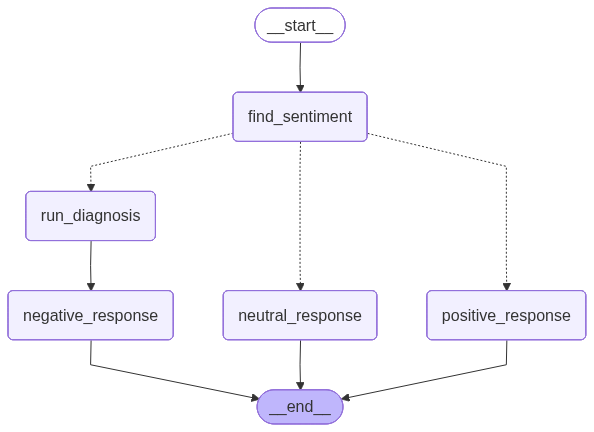

In [106]:
graph = StateGraph(ReviewState)

#nodes
graph.add_node('find_sentiment', find_sentiment_node)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('neutral_response', neutral_response)
graph.add_node('negative_response', negative_response)

#edges
graph.add_edge(START, 'find_sentiment')
graph.add_conditional_edges('find_sentiment', check_sentiment_node)
graph.add_edge('positive_response', END)
graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('negative_response', END)
graph.add_edge('neutral_response', END)

    
workflow = graph.compile()

from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

In [110]:
initial_state = {
    "review": "I had a terrible experience with your product. It stopped working after just two days, and your customer service was unhelpful when I reached out for support."
}
result = workflow.invoke(initial_state)
print(result)

{'review': 'I had a terrible experience with your product. It stopped working after just two days, and your customer service was unhelpful when I reached out for support.', 'sentiment': 'negative', 'diagnosis': {'issue': 'technical', 'tone': 'frustrated', 'urgency': 'high'}, 'response': "Subject: We’re Here to Help - Your Feedback Matters\n\nDear [Customer's Name],\n\nThank you for taking the time to share your experience. I’m truly sorry to hear about the issues you faced with our product and the frustration you encountered with our customer service. Your feedback is invaluable, and it’s clear we fell short in both delivering a quality product and providing the support you deserved.\n\nWe understand how disappointing it can be when a product does not meet your expectations, especially so shortly after purchase. We strive to ensure that all our products are of the highest quality, and I apologize that we did not achieve that in your case.\n\nTo address the technical issue, I would like